# <h1 style="text-align: center; font-weight: bolder;">FINAL PROJECT </h1>


# <h2 style="text-align: LEFT; font-weight: bolder;">Summary </h2>

In this final project we will be exploring time and frequency representations along with DSP tools (Part 1 & 2) to transform a short melodic phrase into a musical piece (Part 2 option b).

Overall instructions:


What you'll find done here:
* Download and preprocess of the audio: mono, 44.1 KHz, trimming and normalization.
* Analyze the signal in the time and frequency domain: waveform, STFT specftogram, descriptors.
* Pitch estimation and visualization over the spectrogram.
* Design and a apply a creative transformartion to build a small composition.
* Build a small composition by harmonizing the original phrase.
* Analyze the final mix with spectrograms.
* Raw easurement of the computational and enviromental impact.

The code is implemented in Python using mainly numpy, scipy, soundfile and matplotlib, and runs in a notebook environment.

<a id="dataprep"></a>
## <h4>DATA PREP & SETUP</h4>


In this section we find:
* Importa of numerical and signal processing libraries
* Configuration for plotting with matplotlib
* Load audio, system monitoring and energy tracking tools
    * soundfile: for r/w wav files
    * psutil: for CPU and memory measurment
    * CodeCarbon: to estimate CO2 emissions
* Definition of local "sounds" directory for all audio files and a codecarbon_logs folder for emission logs.
* Setup of Manuel Castillo's Freesound API key and the sound ID that will be used.

At the end of the setup, CodeCarbon tracker is intialized.

In [1]:
import numpy as np
import math
import os
import requests
import time

from scipy.signal import resample_poly, stft, istft
import matplotlib.pyplot as plt
import IPython.display as ipd

%matplotlib inline

# For google colab

import sys

# soundfile
try:
    import soundfile as sf
except ImportError:
    !{sys.executable} -m pip install soundfile
    import soundfile as sf

# psutil
try:
    import psutil
except ImportError:
    !{sys.executable} -m pip install psutil
    import psutil

# codecarbon
try:
    from codecarbon import OfflineEmissionsTracker
except ImportError:
    !{sys.executable} -m pip install codecarbon
    from codecarbon import OfflineEmissionsTracker

# testing purposes 
try:
    import librosa, librosa.display
except ImportError:
    !{sys.executable} -m pip install librosa
    import librosa, librosa.display

# base dir for sounds
BASE_DIR = "sounds"
os.makedirs(BASE_DIR, exist_ok=True)

# Freesound API
API_KEY = "RyxVkKLbV8VUlkfb4QShilfmPTgevqv6BfEBEhTV"  
# universildo/sounds/415627
SOUND_ID = 415627                   

In [2]:
from codecarbon import OfflineEmissionsTracker

# carpeta donde se guardará emissions.csv
os.makedirs("codecarbon_logs", exist_ok=True)

tracker = OfflineEmissionsTracker(
    project_name="DSP_Final_Project",
    output_dir="codecarbon_logs",
    # España - GTM para Guate
    country_iso_code="ESP",  
    # muestreo cada 1s 
    measure_power_secs=1      
)

tracker.start()
print("CodeCarbon tracker: STARTED")

[codecarbon INFO @ 09:41:20] offline tracker init
[codecarbon WARNING @ 09:41:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 09:41:20] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 09:41:20] [setup] RAM Tracking...
[codecarbon INFO @ 09:41:20] [setup] CPU Tracking...
[codecarbon WARNING @ 09:41:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 09:41:21] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon WARNING @ 09:41:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:41:21] [setup] GPU Tracking...
[codecarbon INFO @ 09:41:21] No GPU found.
[codecarbon INFO @ 09:41:21] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model

CodeCarbon tracker: STARTED


# <h2 style="text-align: center; font-weight: bolder;">PART 1 </h2>


# SOUND DOWNLOAD AND EDITION

* Audio used for project: short monophpnic and melodic phrase from Freesound with ID 415627, user universildo.
* Sound is downloaded via de Freesound API.
* In the setup we also put a try catch/except for whenever freesound is down, as it happen during the development of this final project. To handle in general:
    * Network or API errors
    * Invalid API keys or downtime in Freesound
* Fall back strategy:
    * If the API fails, first search for a previously downloaded file in the local sounds folder
    * If nothing is found and we are in Colab, I ask the user to upload a file.
    * Otherwise, a manual path is asked in VS code or similar.


**URL for audio saved in private cloud: https://drive.google.com/file/d/1dsKfV776V8kSiHbqOtkRTkam3cyKBjem/view?usp=sharing**


In [3]:
# mapping de descriptores (como en ej 9)
descriptorMapping = {
    0: 'lowlevel.spectral_centroid.mean',
    1: 'lowlevel.dissonance.mean',
    2: 'lowlevel.hfc.mean',
    3: 'sfx.logattacktime.mean',
    4: 'sfx.inharmonicity.mean',
    5: 'lowlevel.spectral_contrast.mean.0',
    6: 'lowlevel.spectral_contrast.mean.1',
    7: 'lowlevel.spectral_contrast.mean.2',
    8: 'lowlevel.spectral_contrast.mean.3',
    9: 'lowlevel.spectral_contrast.mean.4',
    10: 'lowlevel.spectral_contrast.mean.5',
    11: 'lowlevel.mfcc.mean.0',
    12: 'lowlevel.mfcc.mean.1',
    13: 'lowlevel.mfcc.mean.2',
    14: 'lowlevel.mfcc.mean.3',
    15: 'lowlevel.mfcc.mean.4',
    16: 'lowlevel.mfcc.mean.5'
}

# convierte dict de features a vector (como en eje 9)
def convFtrDict2List(ftrDict):
    ftr = []
    for key in range(len(descriptorMapping.keys())):
        try:
            ftrName, ind = '.'.join(descriptorMapping[key].split('.')[:-1]), int(descriptorMapping[key].split('.')[-1])
            ftr.append(ftrDict[ftrName][0][ind])
        except:
            ftr.append(ftrDict[descriptorMapping[key]][0])
    return np.array(ftr)

# convierte analysis_json de freesound al formato que convFtrDict2List necesita
def convAnalysisJson2Flat(analysis_json, descriptorMapping):
    ftrDict = {}
    for idx, desc_name in descriptorMapping.items():
        # ['lowlevel','mfcc','mean','0'] etc
        parts = desc_name.split('.')    
        # lowlevel o sfx        
        group = parts[0]        
        # mfcc, spectral_centroid, etc                
        feat = parts[1]   
        # mean                      
        stat = parts[2]                         
        
        val = None
        try:
            # subnodo relevante
            node = analysis_json[group][feat]   
            
            # caso escalar: lowlevel.hfc.mean, sfx.logattacktime.mean, etc
            if len(parts) == 3:
                val = node[stat]
            
            # caso vector: lowlevel.mfcc.mean.3, spectral_contrast.mean.4, etc
            elif len(parts) == 4:
                i = int(parts[3])
                val = node[stat][i]
        
        except:
            val = None
        
        # fallback si no hay valor (medio pseudo trycatch)
        if val is None:
            ftrDict[desc_name] = [0.0]
        else:
            ftrDict[desc_name] = [float(val)]
    
    return ftrDict

In [4]:
import json

def convAnalysisJson2Flat(analysis_json, descriptorMapping):
    
    ftrDict = {}
    #ftrDictTest = {}

    for idx, desc_name in descriptorMapping.items():
        # expectsss ['lowlevel','mfcc','mean','0'] o ['lowlevel','spectral_centroid','mean']
        parts = desc_name.split('.')  
        
        group = parts[0]   
        feat  = parts[1]   
        stat  = parts[2]   

        val = None
        try:
            node = analysis_json[group][feat]

            if len(parts) == 3:
                val = node[stat]

            elif len(parts) == 4:
                idx_coef = int(parts[3])
                # Freesound: list/array
                vec = node[stat]         
                val = vec[idx_coef]

        except Exception:
            val = None

        if val is None:
            ftrDict[desc_name] = [0.0]
        else:
            ftrDict[desc_name] = [float(val)]

    return ftrDict

In [5]:
# try/except para evitar crash si freesound esta down o la api falla
use_freesound = True
raw_path = None

try:
    # metadata url
    meta_url = f"https://freesound.org/apiv2/sounds/{SOUND_ID}/?token={API_KEY}"
    
    # request metadata
    meta_response = requests.get(meta_url, timeout=10)

    if not meta_response.ok:
        print("HTTP status:", meta_response.status_code)
        print("response text:", meta_response.text)
        raise RuntimeError("Error al pedir metadata de Freesound: API key o ID")
    
    meta = meta_response.json()

    # preview-hq-ogg
    preview_url = meta["previews"]["preview-hq-ogg"]
    print("Audio title:", meta.get("name", ""))
    print("Duration in seconds:", meta.get("duration", "N/A"))
    print("Preview URL:", preview_url)

    # preview download
    raw_path = os.path.join(BASE_DIR, f"universildo_{SOUND_ID}_preview.ogg")
    audio_response = requests.get(preview_url, timeout=10)
    if not audio_response.ok:
        print("Audio HTTP status:", audio_response.status_code)
        raise RuntimeError("No se pudo descargar el preview de Freesound")

    with open(raw_path, "wb") as f:
        f.write(audio_response.content)

    print("Descarga desde Freesound OK")

except Exception as e:
    print("===========================================")
    print("ACHTUNG! ADVERTÈNCIA! ALERTE!:")
    print("Freesound not available o error en API:")
    print(e)
    print("===========================================\n")

    # primero intentar encontrar el archivo localmente en la carpeta sounds
    candidate_paths = []

    # buscar cualquier archivo en sounds/ que contenga el SOUND_ID en el nombre
    for fname in os.listdir(BASE_DIR):
        if str(SOUND_ID) in fname and fname.lower().endswith(('.wav', '.ogg', '.mp3', '.flac', '.aiff')):
            candidate_paths.append(os.path.join(BASE_DIR, fname))

    if len(candidate_paths) > 0:
        # usar el primero encontrado
        raw_path = candidate_paths[0]
        print("Found existing local file in sounds folder:")
        for p in candidate_paths:
            print("  -", p)
        print("Using:", raw_path)
    else:
        # si no se encontró nada en sounds, pedir al usuario

        # detectar si estamos en colab
        in_colab = False
        try:
            import google.colab
            in_colab = True
        except ImportError:
            in_colab = False

        if in_colab:
            print("Sube un archivo de audio manualmente (Colab).")
            from google.colab import files
            uploaded = files.upload()
            filename = list(uploaded.keys())[0]
            raw_path = filename
            print("File uploaded:", raw_path)

        else:
            # fallback: pedir ruta manual por consola (sin tkinter)
            print("Could not use Freesound and no local file was found in sounds folder.")
            raw_path = input("Enter full local path to an audio file: ").strip()
            #if raw_path is None or raw_path == "":
            if raw_path is None or raw_path == "":
                
                raise RuntimeError("No compatible file was selected.")
            print("File selected:", raw_path)


# -------------------------------------------------------------------------
# read audio
x_raw, fs_raw = sf.read(raw_path)
print("fs_raw:", fs_raw, "shape:", x_raw.shape)

# convertir a mono
if x_raw.ndim > 1:
    x_mono = np.mean(x_raw, axis=1)
else:
    x_mono = x_raw

# sample to 44.1
fs_target = 44100
if fs_raw != fs_target:
    g = math.gcd(fs_raw, fs_target)
    up = fs_target // g
    down = fs_raw // g
    x_resampled = resample_poly(x_mono, up, down)
    fs_proc = fs_target
else:
    x_resampled = x_mono
    fs_proc = fs_raw

# OJO: PARA CUANDO TENGAMOS QUE AJSUTAR
# audio trim:  
start_sec = 9.0   
# max duracion. no cuando termina
# probamos con 4 para que al ponerle bpm de 120 no hay problemas de tempo  
max_dur_sec = 4

dur_total = len(x_resampled) / fs_proc
print("Total duration in s:", dur_total)

# config anti error
# si el start_sec está fuera de rango, lo reajustamos
if start_sec >= dur_total:
    print("WARNING: start_sec is greater than or equal to total duration.")
    print("Resetting start_sec = 0.0")
    start_sec = 0.0

start_sample = int(start_sec * fs_proc)
end_sample = start_sample + int(max_dur_sec * fs_proc)
end_sample = min(end_sample, len(x_resampled))

x_edit = x_resampled[start_sample:end_sample]

# si por cualquier motivo el recorte queda vacío, usar todo el audio
if len(x_edit) == 0:
    print("WARNING: trimmed segment is empty. Using full signal instead.")
    x_edit = x_resampled.copy()

print("Duration for assignment in s:", len(x_edit) / fs_proc)

# normalization
# deletable
peak = np.max(np.abs(x_edit)) + 1e-9
x_edit = x_edit / peak * 0.9

# save in with following configuraciones> wav, mono, 44.1 khz, 16 bit
edited_path = os.path.join(BASE_DIR, f"universildo_{SOUND_ID}_edit.wav")
sf.write(edited_path, (x_edit * 32767).astype(np.int16), fs_proc)
print("Saved in path:", edited_path)


print("Saved in path:", edited_path)

ipd.Audio(x_edit, rate=fs_proc)

Audio title: Flauta de armónicos.wav
Duration in seconds: 21.375
Preview URL: https://cdn.freesound.org/previews/415/415627_2750323-hq.ogg


[codecarbon INFO @ 09:41:22] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:22] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:22] Energy consumed for All CPU : 0.000001 kWh
[codecarbon INFO @ 09:41:22] 0.000003 kWh of electricity and 0.000000 L of water were used since the beginning.


Descarga desde Freesound OK
fs_raw: 44100 shape: (942638, 2)
Total duration in s: 21.375011337868482
Duration for assignment in s: 4.0
Saved in path: sounds/universildo_415627_edit.wav
Saved in path: sounds/universildo_415627_edit.wav


### Preprocessing: mono conversion, resampling and trimming

Once the audio is downloaded the following preprocessing steps are applied:

* Mono conversion: if the source is stereo, I average the channels to get a single channel waveform
* Resample to 44.1: the signal is resampled with resample_poly to simplify later processing.
* Trim to 4 second fragment
* Normalization: the trimmed segment is peak normalized to avoid clipping.
* The edited audio is saves as a 16 bit mono wav with 44.1 

In [6]:
# intentar obtener analysis json desde freesound (si está dispo arriba)
analysis_json = None

try:
    analysis_url = (
        f"https://freesound.org/apiv2/sounds/{SOUND_ID}/analysis/"
        f"?token={API_KEY}&descriptors=lowlevel,sfx"
    )
    resp = requests.get(analysis_url, timeout=10)

    if not resp.ok:
        raise RuntimeError("error al pedir analysis")

    analysis_json = resp.json()
    print("analysis descargado desde freesound")

except Exception as e:
    print("warning: no se pudo obtener analysis desde freesound")
    print(e)
    analysis_json = None

analysis descargado desde freesound


## Descriptor mapping and feature extraction

Inspired by exercise 9, we define a mapping of 17 descriptors 

* Spectral descriptors
* Temporal descriptors
* MFCCs

If the descriptors are missing I just set them up to 0.

In [7]:
# si tenemos analysis, convertimos a vector de 17 descriptores
ftr_vec = None
if analysis_json is not None:
    ftrDict = convAnalysisJson2Flat(analysis_json, descriptorMapping)
    ftr_vec = convFtrDict2List(ftrDict)
    print("feature vector shape:", ftr_vec.shape)
    print("feature vector:", ftr_vec)
else:
    print("no feature vector disponible (freesound analysis down or audio doesnt have one)")

feature vector shape: (17,)
feature vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## AUDIO ANALYSIS

Analysis of waveform, STFT and descriptors.

Here we will analyze the fragment x_edit in time and domain frequency.

Steps:

1. Waveform inspection
    * plotting and audio for listening
    * audio is a short melodic phrase played in flute
    * theres alternation of notes with smooth amplitude levels
    * no noticeable clicks or large silent gaps
2. STFT and magnitude spectrograms
    * COmpute of STFT using
        * Window hann
        * FFT size 2048
        * hop size 512
    * spectrogram shows clear harmonic stacks and energy in the low mid frequency
3. Note level f0 estimation
    * we want to chacterize the melody so we approximate the onset/offset times of each note
    * apply hann window
    * compute the magnitude
    * search the dominant peak 
    * use the peak frequency as an estimate of the fundamental for that note
4. Basic descriptors
    * I compute RMS, zero crossing rate and average magnitude spectrum.

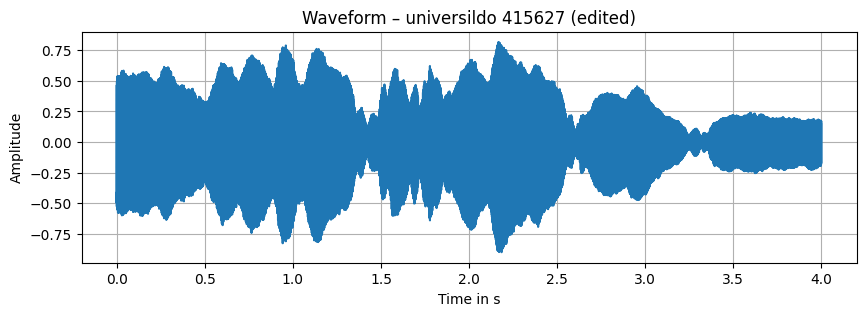

In [8]:
x, fs = sf.read(edited_path)

# aseguramos tipo float32 pero sin reescalar
if x.dtype != np.float32:
    x = x.astype(np.float32)

t = np.arange(len(x)) / fs

plt.figure(figsize=(10, 3))
plt.plot(t, x)
plt.xlabel("Time in s")
plt.ylabel("Amplitude")
plt.title("Waveform – universildo 415627 (edited)")
plt.grid(True)
plt.show()

ipd.Audio(x, rate=fs)

## _STFT and magnitude spectrogram_

[codecarbon INFO @ 09:41:23] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:23] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:23] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 09:41:23] 0.000006 kWh of electricity and 0.000000 L of water were used since the beginning.


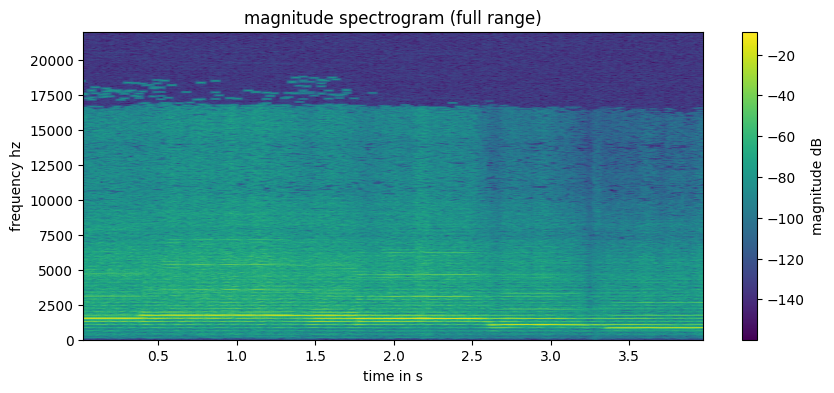

[codecarbon INFO @ 09:41:24] Energy consumed for RAM : 0.000005 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:24] Delta energy consumed for CPU with constant : 0.000002 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:24] Energy consumed for All CPU : 0.000004 kWh
[codecarbon INFO @ 09:41:24] 0.000010 kWh of electricity and 0.000000 L of water were used since the beginning.


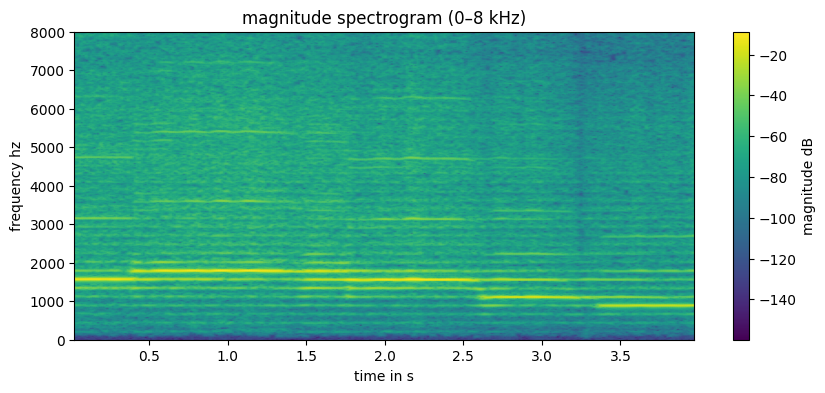

In [9]:
# hagamonos sure que stft and istft exist
# imitemos eje 6
try:
    stft
except NameError:
    from scipy.signal import stft, istft
    
N_fft = 2048
hop = 512
win = "hann"

f, tt, Zxx = stft(
    x,
    fs=fs,
    window=win,
    nperseg=N_fft,
    noverlap=N_fft-hop,
    padded=False,
    boundary=None
)

mag = np.abs(Zxx)

# espectrograma completo
plt.figure(figsize=(10,4))
plt.pcolormesh(tt, f, 20*np.log10(mag+1e-8), shading="gouraud")
plt.colorbar(label="magnitude dB")
plt.xlabel("time in s")
plt.ylabel("frequency hz")
plt.title("magnitude spectrogram (full range)")
plt.ylim(0, fs/2)
plt.show()

# espectrograma con zoom en frecuencias útiles

plt.figure(figsize=(10,4))
plt.pcolormesh(tt, f, 20*np.log10(mag+1e-8), shading="gouraud")
plt.colorbar(label="magnitude dB")
plt.xlabel("time in s")
plt.ylabel("frequency hz")
plt.title("magnitude spectrogram (0–8 kHz)")
plt.ylim(0, 8000)
plt.show()

In [10]:
# Utilidades para f0 por segmento (versión análisis mel)

def estimate_f0_segment_simple(x_seg, fs, fmin=150.0, fmax=2000.0):
    
    if len(x_seg) == 0:
        return None

    w = np.hanning(len(x_seg))
    xw = x_seg * w

    # next power of 2
    N = 1
    while N < len(xw):
        N *= 2

    X = np.fft.rfft(xw, n=N)
    freqs = np.fft.rfftfreq(N, d=1/fs)

    band = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(band):
        return None

    mag = np.abs(X[band])
    if mag.size == 0 or np.all(mag <= 0):
        return None

    idx = np.argmax(mag)
    return freqs[band][idx]


def freq_to_midi(frequency):
    return 69 + 12 * np.log2(frequency / 440.0)


def midi_to_note_name(midi_number):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F','F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_number // 12) - 1
    note = note_names[midi_number % 12]
    return f"{note}{octave}"

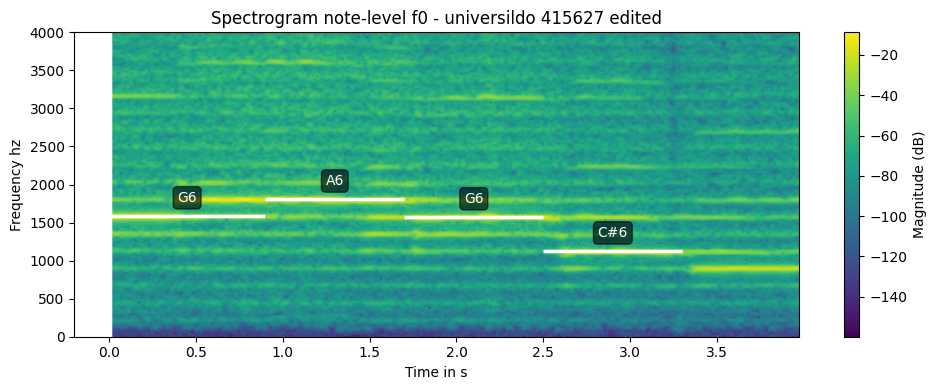

In [11]:
# spectrogram + note-level f0 (tipo Exercise 6) sobre el fragmento editado

# x, fs, f, tt, mag ya vienen del STFT de SciPy de arriba

# tiempos aproximados de cada nota en el fragmento editado
note_times = [0.0, 0.9, 1.7, 2.5, 3.3, 4.2]

# que no se salgan del audio
dur_x = len(x) / fs
note_times = [t for t in note_times if t < dur_x]
if len(note_times) < 2:
    raise RuntimeError("Muy pocos puntos en note_times para segmentar notas.")
note_times[-1] = min(note_times[-1], dur_x)

# estimate de una f0 estable por nota usando el pico del espectro
note_f0s = []
for i in range(len(note_times) - 1):
    s0 = int(note_times[i]   * fs)
    s1 = int(note_times[i+1] * fs)
    seg = x[s0:s1]
    f0_seg = estimate_f0_segment_simple(
        seg, fs,
        fmin=300.0,   
        fmax=3000.0
    )
    note_f0s.append(f0_seg)

# draw de espectrograma (same que arriba, pero con zoom + f0)
plt.figure(figsize=(10, 4))
plt.pcolormesh(tt, f, 20*np.log10(mag + 1e-8), shading="gouraud")
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time in s")
plt.ylabel("Frequency hz")
plt.title("Spectrogram note-level f0 - universildo 415627 edited")

# + líneas horizontales y nombres de nota
for i, f0_seg in enumerate(note_f0s):
    if f0_seg is None or f0_seg <= 0:
        continue

    t0 = note_times[i]
    t1 = note_times[i+1]
    t_center = 0.5 * (t0 + t1)

    # horizontal a la frecuencia estimada
    plt.hlines(
        f0_seg,
        t0,
        t1,
        color="w",
        linewidth=2.5
    )

    # ruta
    midi = int(np.round(freq_to_midi(f0_seg)))
    note_name = midi_to_note_name(midi)
    plt.text(
        t_center,
        f0_seg + 150,   # ojo> un poco por encima de la línea
        note_name,
        color="white",
        fontsize=10,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="black", alpha=0.6, boxstyle="round,pad=0.3")
    )

plt.ylim(0, 4000)   
# otroojo: zoom en la zona donde está la flauta
plt.tight_layout()
plt.show()

## _Descriptors_

Duration in s: 4.000
RMS: 0.2904
Zero Crossing Rate (aprox): 0.0661
Avg spectral centroid in hz: 2392.0


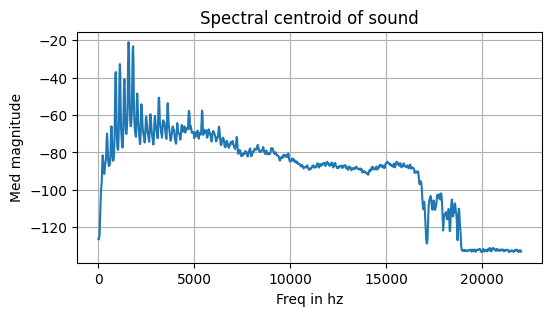

In [12]:

# RMS
rms = np.sqrt(np.mean(x**2))

# zero crossing rate (aprox)
zero_crossings = np.where(np.diff(np.sign(x)))[0]
zcr = len(zero_crossings) / len(x)

# Espectro medio + spectral centroid
X_mean = np.mean(mag, axis=1)  
freqs = f
spectral_centroid = np.sum(freqs * X_mean) / (np.sum(X_mean) + 1e-9)

print(f"Duration in s: {len(x)/fs:.3f}")
print(f"RMS: {rms:.4f}")
print(f"Zero Crossing Rate (aprox): {zcr:.4f}")
print(f"Avg spectral centroid in hz: {spectral_centroid:.1f}")

plt.figure(figsize=(6,3))
plt.plot(freqs, 20*np.log10(X_mean+1e-8))
plt.xlabel("Freq in hz")
plt.ylabel("Med magnitude")
plt.title("Spectral centroid of sound")
plt.grid(True)
plt.show()

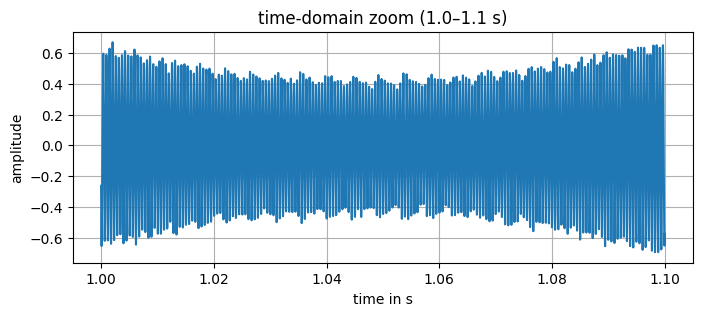

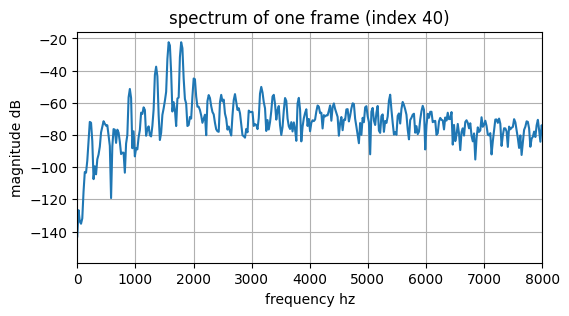

In [13]:
# zoom temporal de un pequeño fragmento
seg_start = 1.0   # s
seg_dur = 0.1     # 100 ms
s0 = int(seg_start * fs_proc)
s1 = min(len(x_edit), s0 + int(seg_dur * fs_proc))

t_seg = np.arange(s0, s1) / fs_proc

plt.figure(figsize=(8,3))
plt.plot(t_seg, x_edit[s0:s1])
plt.xlabel("time in s")
plt.ylabel("amplitude")
plt.title("time-domain zoom ({}–{} s)".format(seg_start, seg_start+seg_dur))
plt.grid(True)
plt.show()

# espectro de un frame del espectrograma
frame_idx = 40 
mag_frame = mag[:, frame_idx]

plt.figure(figsize=(6,3))
plt.plot(f, 20*np.log10(mag_frame+1e-8))
plt.xlabel("frequency hz")
plt.ylabel("magnitude dB")
plt.title("spectrum of one frame (index {})".format(frame_idx))
plt.xlim(0, 8000)  # zoom en armónicos
plt.grid(True)
plt.show()

# <h2 style="text-align: center; font-weight: bolder;">PART 2 </h2>
<h3><b>OPTION B</h3>


## _Base analysis_

In [14]:

def stft_analysis(x, fs, N_fft=2048, hop=512, win="hann"):
    f, t, Z = stft(
        x, fs=fs, window=win,
        nperseg=N_fft,
        noverlap=N_fft-hop,
        padded=False,
        boundary=None
    )
    return f, t, Z

def stft_synthesis(Z, fs, N_fft=2048, hop=512, win="hann"):
    _, x_rec = istft(
        Z, fs=fs, window=win,
        nperseg=N_fft,
        noverlap=N_fft-hop,
        input_onesided=True
    )
    return x_rec

# analysis & sintesis without transformacion
N_fft_base = 2048
hop_base = 512

f_base, t_base, Z_base = stft_analysis(x, fs, N_fft=N_fft_base, hop=hop_base)
x_rec = stft_synthesis(Z_base, fs, N_fft=N_fft_base, hop=hop_base)

# length adj
min_len = min(len(x), len(x_rec))
x_rec = x_rec[:min_len]
x_ref = x[:min_len]

# if hay reconstruction error
err = np.sqrt(np.mean((x_ref - x_rec)**2))
print(f"RMSE entre original y reconstruido: {err:.6f}")

ipd.Audio(x_rec, rate=fs)

RMSE entre original y reconstruido: 0.399310


## 2.2 Individual transformations

In [15]:

# useful for pitch shift
def transform_pitch_resample(x, fs, semitones):
    factor = 2 ** (semitones / 12.0)
    y = resample_poly(x, up=int(1000*factor), down=1000)
    fs_new = int(fs * factor)
    return y, fs_new

# simp low pass filter
def transform_lowpass_fft(x, fs, cutoff_hz):
    N = len(x)
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    
    H = (freqs <= cutoff_hz).astype(float)
    Y = X * H
    y = np.fft.irfft(Y, n=N)
    return y

#highlights
def transform_brighten_spectral_tilt(x, fs, tilt_db_per_khz=6.0):
    f, t, Z = stft_analysis(x, fs, N_fft=2048, hop=512)
    mag = np.abs(Z)
    phase = np.angle(Z)
    
    freqs = f / 1000.0  # kHz
    tilt = tilt_db_per_khz * freqs
    tilt_lin = 10 ** (tilt / 20.0)
    
    mag_tilted = mag * tilt_lin[:, np.newaxis]
    Z_tilted = mag_tilted * np.exp(1j * phase)
    
    y = stft_synthesis(Z_tilted, fs, N_fft=2048, hop=512)
    return y

# spec freezing
def transform_spectral_freeze(x, fs, freeze_time=0.5):
   
    f, t, Z = stft_analysis(x, fs, N_fft=2048, hop=512)
    mag = np.abs(Z)
    phase = np.angle(Z)
    
    frame_idx = np.argmin(np.abs(t - freeze_time))
    mag_freeze = mag[:, frame_idx][:, np.newaxis]
    
    # usa fase progresiva para evitar clicks grandes
    phase_freeze = np.unwrap(phase[:, frame_idx][:, np.newaxis], axis=0)
    Z_freeze = mag_freeze * np.exp(1j * phase_freeze)
    
    y = stft_synthesis(Z_freeze, fs, N_fft=2048, hop=512)
    return y

# cut in bits 
def transform_granular_shuffle(x, fs, grain_ms=80):

    
    
    grain_len = int(fs * grain_ms / 1000.0)
    num_grains = len(x) // grain_len
    x_cut = x[:num_grains * grain_len].copy()
    
    grains = x_cut.reshape(num_grains, grain_len)
    order = np.random.permutation(num_grains)
    grains_shuffled = grains[order, :]
    
    y = grains_shuffled.reshape(-1)
    return y

In [16]:

# ver robusta de granular shuffle
def transform_granular_shuffle(x, fs, grain_ms=80):
    
    grain_len = max(1, int(fs * grain_ms / 1000.0))
    num_grains = len(x) // grain_len

    # if not enough, no hacemos nada aleatorio
    if num_grains < 2:
        return x.copy()

    x_cut = x[:num_grains * grain_len].copy()
    grains = x_cut.reshape(num_grains, grain_len)

    order = np.random.permutation(num_grains)
    grains_shuffled = grains[order, :]

    y = grains_shuffled.reshape(-1)
    return y


# generate variations
variations = {}

# NUEVAS FUNCIONES: time-stretch + delay + reverb 

from scipy.signal import fftconvolve

def time_stretch_phase_vocoder(x, fs, stretch=1.3, N_fft=2048, hop=512):

    # STFT
    f, t, Z = stft(
        x,
        fs=fs,
        window="hann",
        nperseg=N_fft,
        noverlap=N_fft - hop,
        padded=False,
        boundary=None
    )

    mag = np.abs(Z)
    phase = np.angle(Z)

    num_bins, num_frames = Z.shape
    new_num_frames = int(np.ceil(num_frames * stretch))

    Y = np.zeros((num_bins, new_num_frames), dtype=np.complex64)

    # avance de fase teórico
    omega = 2.0 * np.pi * hop * np.arange(num_bins) / float(N_fft)

    # inicializamos acumulador de fase con el primer frame
    phase_acc = phase[:, 0].copy()
    Y[:, 0] = mag[:, 0] * np.exp(1j * phase_acc)

    # recorremos los frames nuevos
    for n in range(1, new_num_frames):
        t_orig = n / stretch
        k = int(np.floor(t_orig))
        if k >= num_frames - 1:
            break

        frac = t_orig - k

        # interpolación lineal de magnitud
        mag_t = (1.0 - frac) * mag[:, k] + frac * mag[:, k + 1]

        # actualización de fase (phase locking simple)
        delta = phase[:, k + 1] - phase[:, k] - omega
        # llevar delta al rango [-pi, pi]
        delta = (delta + np.pi) % (2.0 * np.pi) - np.pi

        phase_acc += omega + delta
        Y[:, n] = mag_t * np.exp(1j * phase_acc)

    # iSTFT
    _, y = istft(
        Y,
        fs=fs,
        window="hann",
        nperseg=N_fft,
        noverlap=N_fft - hop,
        input_onesided=True
    )

    return y.astype(np.float32)

# delay
def apply_simple_delay(x, fs, delay_time=0.28, feedback=0.45, mix=0.35, num_taps=4):
    x = x.astype(np.float32)
    y = x.copy()

    delay_samples = int(delay_time * fs)

    for k in range(1, num_taps + 1):
        d = delay_samples * k
        if d >= len(x):
            break
        y[d:] += (feedback ** k) * x[:-d]

    peak = np.max(np.abs(y)) + 1e-9
    y = y / peak

    return (1.0 - mix) * x + mix * y


# reverb
def apply_simple_reverb(x, fs, reverb_time=1.2, mix=0.4):
   
    x = x.astype(np.float32)

    ir_len = int(reverb_time * fs)
    t_ir = np.arange(ir_len) / fs

    ir = np.exp(-3.0 * t_ir / reverb_time).astype(np.float32)
    ir *= (0.9 + 0.1 * np.random.randn(ir_len)).astype(np.float32)

    y = fftconvolve(x, ir, mode="full")[:len(x)]

    peak = np.max(np.abs(y)) + 1e-9
    y = y / peak

    return (1.0 - mix) * x + mix * y

# pitch up +5 semitonos
y_pitch_up, fs_pitch_up = transform_pitch_resample(x, fs, semitones=5)

# resample back to fs original para compararlo y usarlo luego en la mezcla
y_pitch_up = resample_poly(y_pitch_up, up=fs, down=fs_pitch_up)
variations["pitch_up_+5st"] = y_pitch_up

# low-pass (here 2000 hz)
y_lowpass = transform_lowpass_fft(x, fs, cutoff_hz=2000)
variations["lowpass_2kHz"] = y_lowpass

# brighten (tilt)
y_bright = transform_brighten_spectral_tilt(x, fs, tilt_db_per_khz=6.0)
variations["bright_tilt"] = y_bright

# spectral freeze
y_freeze = transform_spectral_freeze(x, fs, freeze_time=0.5)
variations["spectral_freeze"] = y_freeze

# granular shuffle
np.random.seed(0)  
y_granular = transform_granular_shuffle(x, fs, grain_ms=80)  
variations["granular_shuffle"] = y_granular

# save and play
for name, y in variations.items():
    if y is None or len(y) == 0:
        print(f"{name}: variación vacía, se omite.")
        continue

    # normalization
    peak = np.max(np.abs(y)) + 1e-9
    y_norm = y / peak * 0.9
    out_path = os.path.join(BASE_DIR, f"universildo_{SOUND_ID}_{name}.wav")
    sf.write(out_path, (y_norm * 32767).astype(np.int16), fs)
    print(name, "->", out_path, "dur(s):", len(y_norm)/fs)

# play current result (OJO: change name if saving mulitple)
ipd.Audio(variations["granular_shuffle"], rate=fs)

pitch_up_+5st -> sounds/universildo_415627_pitch_up_+5st.wav dur(s): 3.9975283446712018
lowpass_2kHz -> sounds/universildo_415627_lowpass_2kHz.wav dur(s): 4.0
bright_tilt -> sounds/universildo_415627_bright_tilt.wav dur(s): 3.947392290249433
spectral_freeze: variación vacía, se omite.
granular_shuffle -> sounds/universildo_415627_granular_shuffle.wav dur(s): 4.0


### HARMONIZATION TOOLS


To build a small composition these utilities were designed:
* estimation of the fundamental frequency for short segments
* conversion between frequency and MIDI note numbers
* construction of triads and chrods based on musical intervals
* generation of synthetic baseline

Additionaly:
* I reuse the spectral peak-based f0 estimation (now as estimate_f0_segment) to obtain a stable f0 for each segment. 
* assuming a minor key centered around the main note, I define a function that returns triad intervals for each degree (i, ii, III, iv, v, VI, VII) and use it to:
    * Build triads 
    * Construct syntehtic sinusoidal chords from a root f0 and a list of intervals.
* all chord voices are folded into a restricted frequency range of 150/-440 hz to avoid high pitched annoying sounds
*for the baseline i generate a loop of background chords alternating between i minor (root) and iv major with a flattened 7th relative to the fourth degree.
* i also synthetize a monophonic sinusoidal baseline at several octaves below the root
 



In [17]:

# estimar f0 de un segmento usando el pico espectral más fuerte
def estimate_f0_segment(x_seg, fs, fmin=150.0, fmax=2000.0):
    if len(x_seg) == 0:
        return None
    w = np.hanning(len(x_seg))
    xw = x_seg * w

    # next pow 2
    N = 1
    while N < len(xw):
        N *= 2

    X = np.fft.rfft(xw, n=N)
    freqs = np.fft.rfftfreq(N, d=1/fs)

    band = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(band):
        return None

    mag = np.abs(X[band])
    if mag.size == 0:
        return None

    idx = np.argmax(mag)
    f0 = freqs[band][idx]
    return f0

# utils midi hz
def hz_to_midi(f):
    return 69 + 12 * np.log2(f / 440.0)

def midi_to_hz(m):
    return 440.0 * (2.0 ** ((m - 69) / 12.0))

# decidir intervalos de triada asumiendo modo menor relativo al grado i
def triad_intervals_for_midi(midi_root):
    # relativo al la (57) solo para decidir calidad del acorde
    rel = (midi_root - 57) % 12

    # grados de la menor natural (solo para escoger tipo de triada por grado)
    degree_quality = {
        0: "min",   # i
        2: "dim",   # ii
        3: "maj",   # III
        5: "min",   # iv
        7: "min",   # v
        8: "maj",   # VI
        10: "maj"   # VII
    }

    q = degree_quality.get(rel, "min")
    if q == "maj":
        return [0, 4, 7]
    elif q == "dim":
        return [0, 3, 6]
    else:
        return [0, 3, 7]

# construir una triada a partir de un segmento ( st + resample)
def make_triad_from_segment(x_seg, fs, base_f0=None):
    if len(x_seg) == 0:
        return x_seg

    if base_f0 is None:
        base_f0 = estimate_f0_segment(x_seg, fs)

    if base_f0 is None or base_f0 <= 0:
        return x_seg.copy()

    midi_root = hz_to_midi(base_f0)
    intervals = triad_intervals_for_midi(midi_root)

    voices = []
    for st in intervals:
        if st == 0:
            voices.append(x_seg.copy())
        else:
            y, fs_y = transform_pitch_resample(x_seg, fs, semitones=st)
            y = resample_poly(y, up=fs, down=fs_y)
            voices.append(y)

    min_len = min(len(v) for v in voices)
    voices = [v[:min_len] for v in voices]

    chord = np.sum(voices, axis=0)
    peak = np.max(np.abs(chord)) + 1e-9
    chord = chord / peak * 0.9
    return chord.astype(np.float32)

# generar una capa de bajo (ojo: params flexibles)
def make_bassline_layer(f0_root, fs, duration_sec, bpm=120,
                        octaves_down=1, note_division="quarters", amp=0.4):
  
    if f0_root is None or f0_root <= 0:
        return np.zeros(int(duration_sec * fs), dtype=np.float32)

    f = f0_root / (2.0 ** octaves_down)
    t = np.arange(int(duration_sec * fs)) / fs
    bass = np.sin(2 * np.pi * f * t)

    if note_division == "quarters":
        beat_dur = 60.0 / bpm
    else:  # "eighths"
        beat_dur = 60.0 / bpm / 2.0

    env = np.zeros_like(bass)
    num_beats = int(duration_sec / beat_dur) + 1

    for b in range(num_beats):
        start = int(b * beat_dur * fs)
        end = min(len(env), start + int(beat_dur * fs * 0.8))
        if start >= len(env):
            break
        seg_len = end - start
        if seg_len <= 0:
            continue

        fade_len = min(int(0.05 * fs), seg_len)
        e = np.ones(seg_len)
        if fade_len > 0:
            e[:fade_len] *= np.linspace(0.0, 1.0, fade_len)
            e[-fade_len:] *= np.linspace(1.0, 0.0, fade_len)
        env[start:end] = np.maximum(env[start:end], e)

    bass *= env
    peak = np.max(np.abs(bass)) + 1e-9
    bass = bass / peak * amp
    return bass.astype(np.float32)

# generar un acorde a partir de f0_root y lista de intervalos (en semitonos)
def make_chord_from_f0(f0_root, fs, duration_sec, intervals, amp=0.3):
    """
    Genera un acorde sinusoidal a partir de una frecuencia raíz y una lista de
    intervalos en semitonos, limitando TODAS las voces al rango [150, 440] Hz.
    """
    if f0_root is None or f0_root <= 0:
        return np.zeros(int(duration_sec * fs), dtype=np.float32)

    t = np.arange(int(duration_sec * fs)) / fs
    sig = np.zeros_like(t, dtype=np.float32)

    min_f = 150.0
    max_f = 440.0

    for st in intervals:
        # frecuencia teorica
        f = f0_root * (2.0 ** (st / 12.0))

        # plegamos por octavas hasta que quede en [min_f, max_f]
        while f > max_f:
            f /= 2.0
        while f < min_f:
            f *= 2.0

        # sumamos esta voz
        sig += np.sin(2.0 * np.pi * f * t).astype(np.float32)

    peak = np.max(np.abs(sig)) + 1e-9
    sig = sig / peak * amp
    return sig.astype(np.float32)

# acordes de fondo: loop entre i menor y iv mayor con séptima "disminuida" (b7) - validar si ese es el nombre 
def make_background_chords(f0_root, fs, duration_sec, bpm=120):
   
    if f0_root is None or f0_root <= 0:
        return np.zeros(int(duration_sec * fs), dtype=np.float32)

    bar_sec = 4 * 60.0 / bpm   # un compás de 4/4
    chords = []
    t_acc = 0.0
    toggle = 0

    while t_acc < duration_sec + 1e-3:
        if toggle % 2 == 0:
            # grado i: triada menor
            f_root = f0_root
            intervals = [0, 3, 7]
        else:
            # grado iv: triada mayor + b7 (0, 4, 7, 10)
            f_root = f0_root * (2.0 ** (5.0 / 12.0))
            intervals = [0, 4, 7, 10]

        chord = make_chord_from_f0(f_root, fs, bar_sec, intervals, amp=0.25)
        chords.append(chord)

        t_acc += bar_sec
        toggle += 1

    pad = np.concatenate(chords)
    total_samples = int(duration_sec * fs)

    if len(pad) > total_samples:
        pad = pad[:total_samples]
    else:
        pad = np.pad(pad, (0, total_samples - len(pad)))

    return pad.astype(np.float32)

### SEGEMENT NOTEES, CREATE TRIADS AND MIX


We will build the main them with an intro, chords and bassline.

I decided I wnted to transform the 4s flute phrase into a longer musical piece with this clear structure:

1. Intro of 4s aprox 
    * Using the original flute segment as an intro
    * SLight time stretch the last not to match the 120 tempo at 4/4
        * For this also a shor 0.5s gap of silence for a mini breath

2. Harmonic progression of 16s aprox
    * using the estimated root i define a simple progression with this structure:
        * i - iv - II
            * root minor triad - major triad with minor 7th - major 7 chord
    * i set the patter per cycle at each bar 2 s aprox at 120 bpm
    * repeat the cycle

3. Outro with a chord from the root

In [ ]:



# 1 Segmentamos las primeras notas para estimar f0_root
note_times = [0.0, 0.9, 1.7, 2.5, 3.3, 4.2]  
note_segments = []

for i in range(len(note_times) - 1):
    s0 = int(note_times[i] * fs)
    s1 = int(note_times[i+1] * fs)
    seg = x[s0:s1]
    note_segments.append(seg)

print("número de segmentos de nota:", len(note_segments))

# estimamos f0_root como la primera f0 válida
f0_root = None
for seg in note_segments:
    f0_seg = estimate_f0_segment(seg, fs)
    if f0_seg is not None and f0_seg > 0:
        f0_root = f0_seg
        break

print("f0_root estimada:", f0_root)

if f0_root is None or f0_root <= 0:
    f0_root = 440.0  # fallback por si acaso

# 2 Intro base: 4 segundos SOLO flauta original (sin acordes, sin bajo)
intro_dur_sec = 4.0
intro_samples = int(intro_dur_sec * fs)

# si el recorte es más corto que 4s, lo repetimos
def tile_to_len(sig, L):
    if len(sig) == 0:
        return np.zeros(L, dtype=np.float32)
    reps = int(np.ceil(L / len(sig)))
    out = np.tile(sig, reps)[:L]
    return out.astype(np.float32)

if len(x) >= intro_samples:
    intro = x[:intro_samples]
else:
    intro = tile_to_len(x, intro_samples)

intro = intro.astype(np.float32)

# 2b Prolongar levemente la última nota y añadir una pausa de 0.5 s
if len(note_segments) > 0:
    last_note_seg = note_segments[-1].astype(np.float32)
    # pequeño time stretch de la ultima nota
    y_last = time_stretch_phase_vocoder(last_note_seg, fs, stretch=1.5)
    y_last = y_last.astype(np.float32)

    # evitar el ataque,  solo la "cola" extra
    if len(y_last) > len(last_note_seg):
        y_tail = y_last[len(last_note_seg):]
    else:
        y_tail = y_last

    gap = np.zeros(int(0.5 * fs), dtype=np.float32)  # pausa de medio segundo
    intro_global = np.concatenate([intro, y_tail, gap]).astype(np.float32)
else:
    intro_global = intro.astype(np.float32)

print("duración intro_global (s):", len(intro_global) / fs)

print("duración intro_global (s):", len(intro_global) / fs)

# ===== INICIO MEDICIÓN RECURSOS (Parte 2 armonizacion =====
process = psutil.Process()
cpu_start = process.cpu_times()
mem_start = process.memory_info().rss
t0 = time.time()
# ===================================================================

# 3 Construimos la progresión de acordes base (forzamos 16 s apro)

#bpm = 100

# queremos allegro o casi presto
bpm = 120
bar_sec = 4 * 60.0 / bpm   # 4/4  2 s por compás
n_cycles = 2               # 4 compases * 2 ciclos = 8 compases aprox 16 s

progression_bars = []

# frecuencias root PARA CADA GRADO, UNA OCTAVA MÁS GRAVE
f_i   = f0_root / 2.0                                # i una octava abajo
f_iv  = f0_root * (2.0 ** (5.0 / 12.0)) / 2.0        # iv - 1 octava
f_iii = f0_root * (2.0 ** (3.0 / 12.0)) / 2.0        # III - 1 octava

# intervalos de los acordes:
intervals_i      = [0, 3, 7]          # i: triada menor
intervals_iv7b   = [0, 4, 7, 10]      # iv7(b7): triada mayor + 7a menor
intervals_iii7   = [0, 4, 7, 11]      # IIImaj7 (séptima mayor)

for _ in range(n_cycles):
    # i menor
    progression_bars.append(
        make_chord_from_f0(f_i, fs, bar_sec, intervals_i, amp=0.5)
    )
    # iv7(b7)
    progression_bars.append(
        make_chord_from_f0(f_iv, fs, bar_sec, intervals_iv7b, amp=0.5)
    )
    # III7 (aqu maj7)
    progression_bars.append(
        make_chord_from_f0(f_iii, fs, bar_sec, intervals_iii7, amp=0.5)
    )
    # iv7(b7) otra vez
    progression_bars.append(
        make_chord_from_f0(f_iv, fs, bar_sec, intervals_iv7b, amp=0.5)
    )

chords_prog = np.concatenate(progression_bars).astype(np.float32)

# aseguramos que la section  armonica es EXACTAMENTE 16 s
chord_section_sec = 16.0
harm_section_len = int(chord_section_sec * fs)

if len(chords_prog) > harm_section_len:
    chords_prog = chords_prog[:harm_section_len]
else:
    chords_prog = np.pad(chords_prog, (0, harm_section_len - len(chords_prog)))

print("duración sección acordes base (s):", len(chords_prog) / fs)

# pequeño fade-in para que los acordes no entren de golpe: poquito attack
fade_in_sec = 2.0
fade_samples = min(int(fade_in_sec * fs), len(chords_prog))

env = np.ones_like(chords_prog, dtype=np.float32)
env[:fade_samples] = np.linspace(0.0, 1.0, fade_samples).astype(np.float32)
chords_prog = chords_prog * env

# 4 Melodía extendida después de la intro_global:
#    cada nota 4× su duración, con delay + reverb

note_stretch_factor = 4.0  # nota original + 3× su tiempo adicional

extended_segments = []
for seg in note_segments:
    if len(seg) == 0:
        continue
    y_ext = time_stretch_phase_vocoder(seg.astype(np.float32), fs, stretch=note_stretch_factor)
    extended_segments.append(y_ext.astype(np.float32))

if len(extended_segments) > 0:
    extended_melody = np.concatenate(extended_segments).astype(np.float32)
else:
    # fallback silencioso si algo sale mal
    extended_melody = np.zeros(harm_section_len, dtype=np.float32)

# ajuste de la longitud de la melodía extendida a la sección armónica (16 s)
if len(extended_melody) < harm_section_len:
    extended_melody = np.pad(extended_melody, (0, harm_section_len - len(extended_melody)))
else:
    extended_melody = extended_melody[:harm_section_len]

# Delay para darle movimiento rítmico
melody_body = apply_simple_delay(
    extended_melody,
    fs,
    delay_time=0.28,   # aprox corchea con swing a 120 bpm
    feedback=0.45,
    mix=0.35
)

# Reverb sencilla para dar espacio
melody_body = apply_simple_reverb(
    melody_body,
    fs,
    reverb_time=1.2,
    mix=0.4
)

# Pista completa: intro_global (con last nota prolongada + pausa)
# + cuerpo extendido (16 s)
melody_track = np.concatenate([intro_global, melody_body]).astype(np.float32)

# 5 "Cama" de armonia: silencio durante toda la intro_global + acordes después
harm_intro_silence = np.zeros(len(intro_global), dtype=np.float32)
theme_harm = np.concatenate([harm_intro_silence, chords_prog]).astype(np.float32)

# 6 duración total del tema
assert len(melody_track) == len(theme_harm)
total_sec = len(melody_track) / fs
print("duración total tema (s):", total_sec)

# 7 tres capas de bajo (entrando después de la intro_global 1 s aprox)

bass_quarters = make_bassline_layer(
    f0_root, fs, total_sec,
    bpm=120,
    octaves_down=2,      # 2 octavas abajo
    note_division="quarters",
    amp=0.32
)

bass_eighths = make_bassline_layer(
    f0_root, fs, total_sec,
    bpm=120,
    octaves_down=3,      # 3 octavas abajo
    note_division="eighths",
    amp=0.5
)

bass_eighths_5 = make_bassline_layer(
    f0_root, fs, total_sec,
    bpm=120,
    octaves_down=5,      # 5 octavas abajo
    note_division="quarters",
    amp=0.5
)

bass_sub = make_bassline_layer(
    f0_root, fs, total_sec,
    bpm=120,
    octaves_down=4,      # nueva capa aún más grave
    note_division="quarters",
    amp=0.28
)

# calculamos cuándo empiezan los acordes (fin de la intro_global)
chord_start_sec = len(intro_global) / fs
bass_start_sec = chord_start_sec + 1.0    # bajo entra aprox 1 s después de los acordes
bass_start_samples = int(bass_start_sec * fs)

bass_quarters[:bass_start_samples] = 0.0
bass_eighths[:bass_start_samples] = 0.0
bass_eighths_5[:bass_start_samples] = 0.0
bass_sub[:bass_start_samples]     = 0.0

# 8 Igualamos longitudes (por seguridad)
L = len(melody_track)

def fix_len(y, L):
    if len(y) < L:
        return np.pad(y, (0, L - len(y)))
    else:
        return y[:L]

theme_harm    = fix_len(theme_harm, L)
bass_quarters = fix_len(bass_quarters, L)
bass_eighths  = fix_len(bass_eighths, L)
bass_eighths_5  = fix_len(bass_eighths_5, L)
bass_sub      = fix_len(bass_sub, L)

# 9 mezcla final: flauta + acordes + 3 capas de bajo
mix_theme = melody_track + theme_harm + bass_quarters + bass_eighths + bass_sub + bass_eighths_5

print("len melody_track (s):", len(melody_track)/fs)
print("len theme_harm (s):", len(theme_harm)/fs)

# 10 limitar a 30 s por si acaso
max_total_sec = 30.0
max_samples = int(max_total_sec * fs)
if len(mix_theme) > max_samples:
    mix_theme = mix_theme[:max_samples]

# 11 normalization
peak = np.max(np.abs(mix_theme)) + 1e-9
mix_theme = mix_theme / peak * 0.95

final_path = os.path.join(BASE_DIR, f"universildo_{SOUND_ID}_final_harmonized.wav")
sf.write(final_path, (mix_theme * 32767).astype(np.int16), fs)
print("final harmonized mix saved in:", final_path)
print("length in s:", len(mix_theme)/fs)

# =====================================================
# CODA FINAL: acorde base con ataque + delay + reverb
# =====================================================

# 1 Atenuar un poco el final del tema actual
fade_tail_sec = 0.5          # últimos 0.5 s
fade_tail_samples = min(int(fade_tail_sec * fs), len(mix_theme))

env_tail = np.ones_like(mix_theme, dtype=np.float32)
env_tail[-fade_tail_samples:] = np.linspace(1.0, 0.4, fade_tail_samples).astype(np.float32)
mix_theme_faded = mix_theme * env_tail

#  construccion el último acorde (i menor, acorde base) de  aprox 4 s
final_chord_dur_sec = 4.0    # máx 4 s
intervals_final = intervals_i   # usamos la triada i menor ya definida
f_final_root = f_i              # misma root grave que en la progresión

final_chord = make_chord_from_f0(
    f_final_root,
    fs,
    final_chord_dur_sec,
    intervals_final,
    amp=0.8    # un poquito más presente
)

# 3 envolvente: ataque corto + caída larga
N_final = len(final_chord)
attack_sec = 0.15
attack_samples = min(int(attack_sec * fs), N_final)

attack_env = np.linspace(0.0, 1.0, attack_samples, dtype=np.float32)
sustain_env = np.ones(N_final - attack_samples, dtype=np.float32)
env_final = np.concatenate([attack_env, sustain_env])

# caída global hacia el silencio
decay_env = np.linspace(1.0, 0.0, N_final, dtype=np.float32)
env_final *= decay_env

final_chord *= env_final.astype(np.float32)

# 4 Delay y reverb para que se quede flotando bonito
final_chord = apply_simple_delay(
    final_chord,
    fs,
    delay_time=0.32,   # algo cercano a corchea a 120 bpm
    feedback=0.45,
    mix=0.45,
    num_taps=5
)

final_chord = apply_simple_reverb(
    final_chord,
    fs,
    reverb_time=2.0,   # un poco más larga que el cuerpo
    mix=0.6
)

# 5 Concatenar tema + coda
full_mix = np.concatenate([mix_theme_faded, final_chord]).astype(np.float32)

# 6 Normalización global
peak_full = np.max(np.abs(full_mix)) + 1e-9
full_mix = full_mix / peak_full * 0.95


[codecarbon INFO @ 09:41:25] Energy consumed for RAM : 0.000007 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:25] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:25] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 09:41:25] 0.000013 kWh of electricity and 0.000000 L of water were used since the beginning.


número de segmentos de nota: 5
f0_root estimada: 1584.0362548828125
duración intro_global (s): 4.786848072562358
duración intro_global (s): 4.786848072562358
duración sección acordes base (s): 16.0
duración total tema (s): 20.786848072562357
len melody_track (s): 20.786848072562357
len theme_harm (s): 20.786848072562357
final harmonized mix saved in: sounds/universildo_415627_final_harmonized.wav
length in s: 20.786848072562357


## <h2 style="text-align: center; font-weight: bolder;">FINAL RESULT </h2>


In [ ]:

final_coda_path = os.path.join(BASE_DIR, f"universildo_{SOUND_ID}_final_harmonized_coda.wav")
sf.write(final_coda_path, (full_mix * 32767).astype(np.int16), fs)

print("final mix WITH CODA saved in:", final_coda_path)
print("length in s (with coda):", len(full_mix) / fs)

# === PLAYBACK COMPARATIVO ===

print("1) Audio original EDITADO (solo flauta, 4 s aprox):")
ipd.display(ipd.Audio(x, rate=fs))

print("2) Composición FINAL (tema + acorde final):")
ipd.display(ipd.Audio(full_mix, rate=fs))

final mix WITH CODA saved in: sounds/universildo_415627_final_harmonized_coda.wav
length in s (with coda): 24.786848072562357
1) Audio original EDITADO (solo flauta, 4 s aprox):


2) Composición FINAL con coda (tema + acorde final):


## <h3 style="text-align: center;">EXTRAS</h3>
Measurement of computational usage and environmental impact.

[codecarbon INFO @ 09:41:26] Energy consumed for RAM : 0.000009 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:26] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:26] Energy consumed for All CPU : 0.000007 kWh
[codecarbon INFO @ 09:41:26] 0.000016 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 09:41:27] Energy consumed for RAM : 0.000010 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:27] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:27] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 09:41:27] 0.000019 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 09:41:30] Energy consumed for RAM : 0.000015 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:30] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:30] Energy consumed for All CPU : 0.0

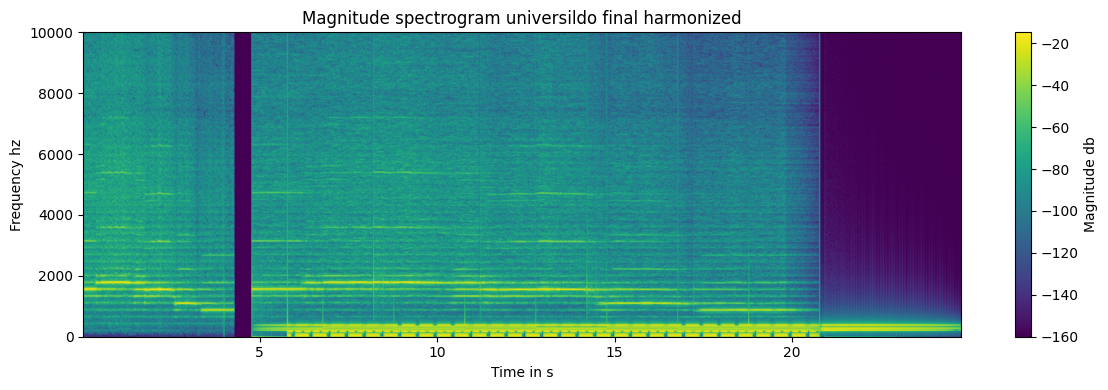

/Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Digital Signal Processing/Repos/dsp-upf/dsp-virtual-3.11/lib/python3.11/site-packages/librosa/core/intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
[codecarbon INFO @ 09:41:31] Energy consumed for RAM : 0.000016 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:31] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:31] Energy consumed for All CPU : 0.000014 kWh
[codecarbon INFO @ 09:41:31] 0.000030 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 09:41:31] 0.000531 g.CO2eq/s mean an estimation of 16.73121775382601 kg.CO2eq/year


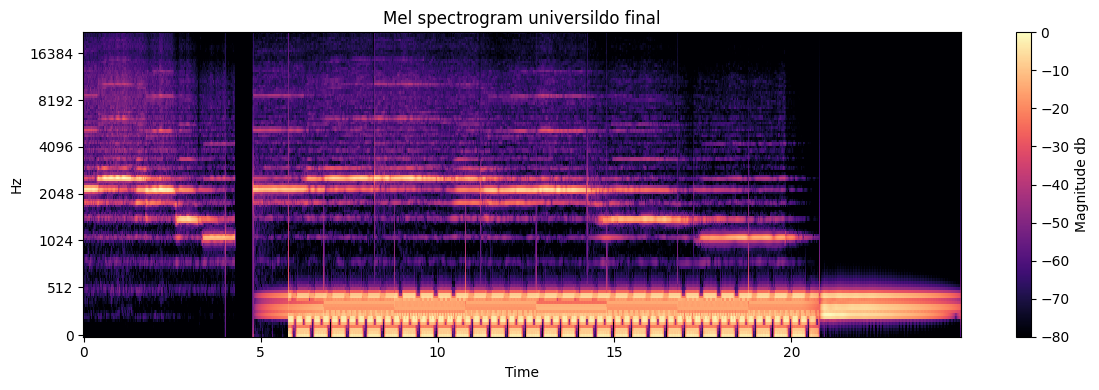

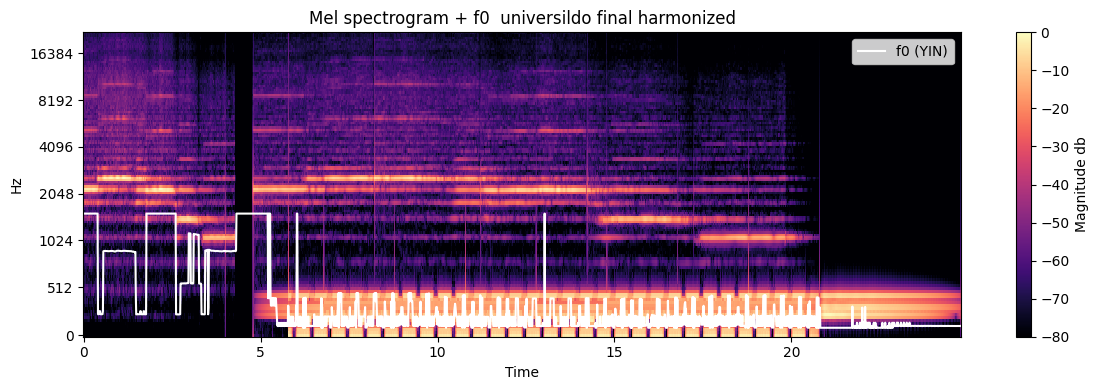

In [20]:

x_full = full_mix.astype(float)
fs_full = fs  

n_fft_full  = 2048
hop_full    = 512
n_mels_full = 128
fmin_full   = 40.0      
fmax_full   = 10000.0   

f_spec, t_spec, Z_spec = stft(
    x_full,
    fs=fs_full,
    window="hann",
    nperseg=n_fft_full,
    noverlap=n_fft_full - hop_full,
    padded=False,
    boundary=None
)
mag_spec = np.abs(Z_spec)

plt.figure(figsize=(12, 4))
plt.pcolormesh(
    t_spec,
    f_spec,
    20 * np.log10(mag_spec + 1e-8),
    shading="gouraud"
)
plt.colorbar(label="Magnitude db")
plt.xlabel("Time in s")
plt.ylabel("Frequency hz")
plt.title("Magnitude spectrogram universildo final harmonized")
plt.ylim(0, 10000)  # mismo rango que el mel
plt.tight_layout()
plt.show()

S_full = librosa.feature.melspectrogram(
    y=x_full,
    sr=fs_full,
    n_fft=n_fft_full,
    hop_length=hop_full,
    n_mels=n_mels_full,
    fmin=fmin_full,
    fmax=fmax_full,
    power=2.0,
)
S_full_db = librosa.power_to_db(S_full, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(
    S_full_db,
    sr=fs_full,
    hop_length=hop_full,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(label="Magnitude db")
plt.title("Mel spectrogram universildo final")
plt.tight_layout()
plt.show()

f0_full = librosa.yin(
    x_full,
    fmin=80.0,
    fmax=1500.0,
    sr=fs_full,
    frame_length=n_fft_full,
    hop_length=hop_full
)
f0_full[f0_full <= 0] = np.nan
times_full = librosa.times_like(f0_full, sr=fs_full, hop_length=hop_full)

plt.figure(figsize=(12, 4))
librosa.display.specshow(
    S_full_db,
    sr=fs_full,
    hop_length=hop_full,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(label="Magnitude db")
plt.plot(times_full, f0_full, color="w", linewidth=1.5, label="f0 (YIN)")
plt.title("Mel spectrogram + f0  universildo final harmonized")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [21]:
# ===== FIN MEDICIÓN RECURSOS (Parte 2) =====
t1 = time.time()
cpu_end = process.cpu_times()
mem_end = process.memory_info().rss

print("\n=== Resource usage part 2 ===")
print(f"Elapsed time: {t1 - t0:.2f} s")
print(f"CPU user time delta: {cpu_end.user - cpu_start.user:.2f} s")
print(f"Max RSS delta (approx): {(mem_end - mem_start)/1e6:.1f} MB")


=== Resource usage part 2 ===
Elapsed time: 6.26 s
CPU user time delta: 6.87 s
Max RSS delta (approx): 2874.7 MB


In [22]:
emissions_kg = tracker.stop()
print(f"\n=== CodeCarbon summary for DSP Final Project ===")
print(f"TOTAL EMISSIONS: {emissions_kg:.8f} kg CO2eq")

print("\nCSV saved in: codecarbon_logs/emissions.csv")

[codecarbon INFO @ 09:41:32] Energy consumed for RAM : 0.000017 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:41:32] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 5.0 W
[codecarbon INFO @ 09:41:32] Energy consumed for All CPU : 0.000014 kWh
[codecarbon INFO @ 09:41:32] 0.000032 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 09:41:32] The CSV format has changed, backing up old emission file.



=== CodeCarbon summary for DSP Final Project ===
TOTAL EMISSIONS: 0.00000554 kg CO2eq

CSV saved in: codecarbon_logs/emissions.csv
